<h1>Import frameworks</h1>

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader


#gpu_device = torch.device("cpu")
#if torch.backends.mps.is_available():
#    gpu_device = torch.device("mps")
#else:
#    print ("MPS device not found.")

<h1>Import datasets</h1>

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = torchvision.datasets.MNIST(root='Assignment6/', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='Assignment6/', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print("train dataset: ", len(train_dataset))
print("test dataset: ", len(test_dataset))



train dataset:  60000
test dataset:  10000


<h1>Plot images</h1>

Image shape: torch.Size([4, 1, 28, 28])
Label shape: torch.Size([4])


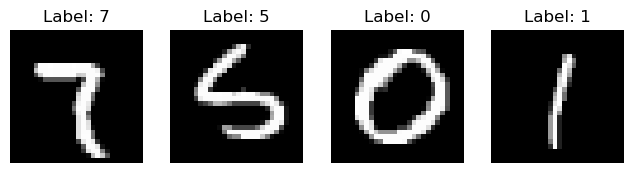

In [11]:

for images, labels in train_loader:
    print("Image shape:", images.size())
    print("Label shape:", labels.size()) 

    fig = plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray') 
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
    fig.savefig('mnist_images.png', bbox_inches='tight')
    break  


<h1>Neural Network</h1>

In [12]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Add ReLU except for the last layer
                layers.append(nn.ReLU())


        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

<h1>Training</h1>

In [13]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs, name):
    train_losses = []  
    test_losses = []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0

        for inputs, labels in train_loader:
            if model.__class__.__name__ == 'NeuralNet':
                inputs = inputs.view(inputs.size(0), -1)
            #inputs, labels = inputs.to(gpu_device), labels.to(gpu_device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        for inputs, labels in test_loader:
            if model.__class__.__name__ == 'NeuralNet':
                inputs = inputs.view(inputs.size(0), -1)
            #inputs, labels = inputs.to(gpu_device), labels.to(gpu_device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
    ax.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    ax.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Test Losses')
    ax.legend()
    plt.show()
    fig.savefig(name  +  ".pdf", bbox_inches='tight')


<h1>Single hidden layer</h1>

Epoch [1/10], Training Loss: 1.6511, Test Loss: 1.9502
Epoch [2/10], Training Loss: 1.6491, Test Loss: 1.5255
Epoch [3/10], Training Loss: 1.5270, Test Loss: 1.3956
Epoch [4/10], Training Loss: 1.4827, Test Loss: 5.2169
Epoch [5/10], Training Loss: 1.5680, Test Loss: 1.5104
Epoch [6/10], Training Loss: 1.5622, Test Loss: 1.5048
Epoch [7/10], Training Loss: 1.6775, Test Loss: 1.8321
Epoch [8/10], Training Loss: 1.7685, Test Loss: 1.8371
Epoch [9/10], Training Loss: 1.7892, Test Loss: 1.8102
Epoch [10/10], Training Loss: 1.7089, Test Loss: 1.7566


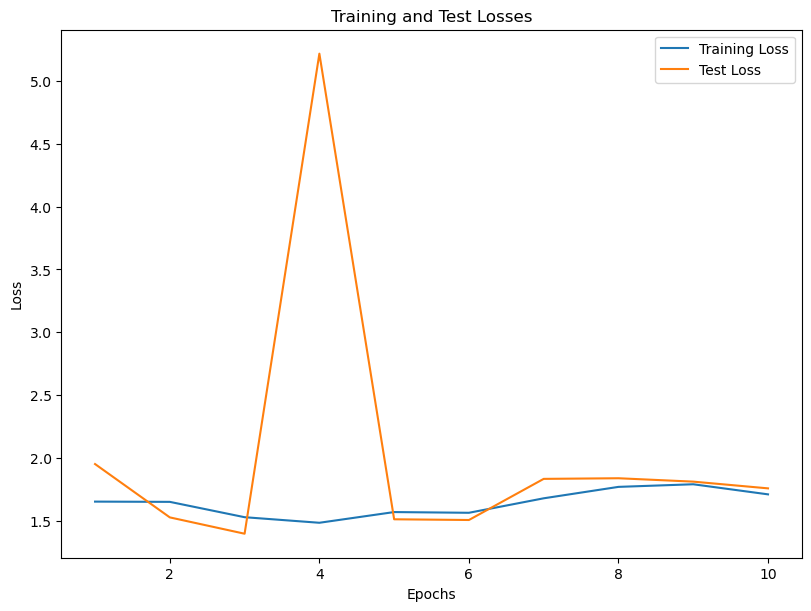

In [14]:
input_size = 28 * 28 
hidden_sizes = [128] # Is 128 the best choice?
output_size = 10  

model = NeuralNet(input_size, hidden_sizes, output_size)
#model = model.to(gpu_device)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "single_hidden_layer")

<h1>Two hidden layer</h1>

Epoch [1/40], Training Loss: 1.2753, Test Loss: 1.6205
Epoch [2/40], Training Loss: 1.6718, Test Loss: 1.7238
Epoch [3/40], Training Loss: 1.8971, Test Loss: 1.9318
Epoch [4/40], Training Loss: 1.9729, Test Loss: 1.9309
Epoch [5/40], Training Loss: 1.9982, Test Loss: 1.9234
Epoch [6/40], Training Loss: 1.9969, Test Loss: 1.9091
Epoch [7/40], Training Loss: 1.9807, Test Loss: 1.9284
Epoch [8/40], Training Loss: 1.9743, Test Loss: 1.9481
Epoch [9/40], Training Loss: 1.9681, Test Loss: 1.9776
Epoch [10/40], Training Loss: 1.9975, Test Loss: 1.9414
Epoch [11/40], Training Loss: 1.9754, Test Loss: 1.9422
Epoch [12/40], Training Loss: 1.9771, Test Loss: 1.9937
Epoch [13/40], Training Loss: 1.9822, Test Loss: 1.9290
Epoch [14/40], Training Loss: 1.9713, Test Loss: 1.9471
Epoch [15/40], Training Loss: 1.9756, Test Loss: 1.9702
Epoch [16/40], Training Loss: 1.9742, Test Loss: 1.9153
Epoch [17/40], Training Loss: 1.9769, Test Loss: 1.9338
Epoch [18/40], Training Loss: 1.9796, Test Loss: 1.9055
E

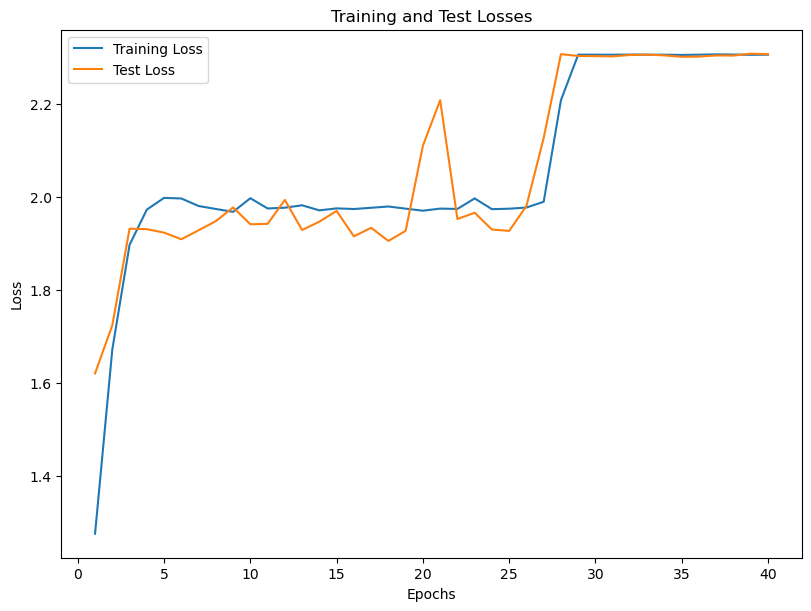

In [15]:
input_size = 28 * 28   
hidden_sizes = [500, 300]  
output_size = 10  
weight_decay = 0.01
model = NeuralNet(input_size, hidden_sizes, output_size)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "two_hidden_layer")



<h1>Convolutional neural network</h1>

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

<h1>Train convolutional neural network</h1>

Epoch [1/40], Training Loss: 0.2649, Test Loss: 0.1591
Epoch [2/40], Training Loss: 0.2276, Test Loss: 0.2713
Epoch [3/40], Training Loss: 0.2430, Test Loss: 0.1865
Epoch [4/40], Training Loss: 0.2383, Test Loss: 0.1499
Epoch [5/40], Training Loss: 0.2318, Test Loss: 0.2052
Epoch [6/40], Training Loss: 0.2270, Test Loss: 0.2796
Epoch [7/40], Training Loss: 0.2360, Test Loss: 0.2581
Epoch [8/40], Training Loss: 0.2378, Test Loss: 0.1280
Epoch [9/40], Training Loss: 0.2375, Test Loss: 0.2119
Epoch [10/40], Training Loss: 0.2340, Test Loss: 0.3060
Epoch [11/40], Training Loss: 0.2373, Test Loss: 0.3384
Epoch [12/40], Training Loss: 0.2469, Test Loss: 0.1249
Epoch [13/40], Training Loss: 0.2424, Test Loss: 0.3056
Epoch [14/40], Training Loss: 0.2426, Test Loss: 0.1265
Epoch [15/40], Training Loss: 0.2368, Test Loss: 0.2423
Epoch [16/40], Training Loss: 0.2407, Test Loss: 0.1734
Epoch [17/40], Training Loss: 0.2400, Test Loss: 0.1733
Epoch [18/40], Training Loss: 0.2366, Test Loss: 0.1937
E

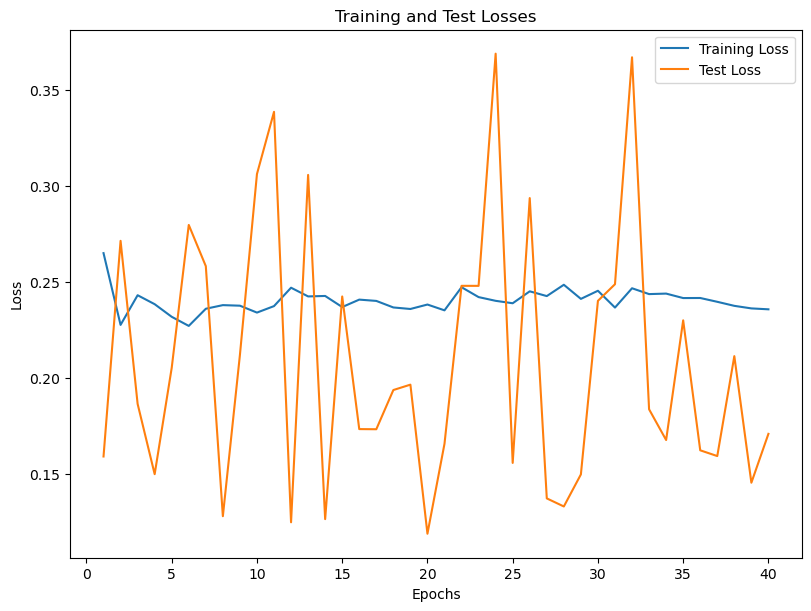

In [17]:

model = CNN()

weight_decay = 0.01
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "cnn")